In [1]:
from PIL import Image, ImageDraw, ImageFont
%matplotlib inline
import numpy as np

import torch
import torch.nn as nn
from skimage import io
import math

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import os

In [2]:
IMG_X, IMG_Y = 200,200 
# length and width of blocks (fixed for now)
block_l, block_w = 20, 30

# img_list = []


# Calc rectangle vertices. makeRectangle() credit Sparkler, stackoverflow, feb 17
def makeRectangle(l, w, theta, offset=(0, 0)):
    c, s = math.cos(theta), math.sin(theta)
    rectCoords = [(l/2.0, w/2.0), (l/2.0, -w/2.0), (-l/2.0, -w/2.0), (-l/2.0, w/2.0)]
    return [(c*x-s*y+offset[0], s*x+c*y+offset[1]) for (x, y) in rectCoords]


# ---- Make depth images ---
def make_dataset(dirname, num_images):
    true_coords = []
    newpath = './' + dirname  
    if not os.path.exists(newpath):
        os.makedirs(newpath)
        print(newpath)
    for i in range(num_images):
        #orient = 0 # degrees
        img = Image.new('RGB', (IMG_X, IMG_Y), 'black')

        # block_l and _w offset so blocks don't run off edge of image 
        rand_x = int(np.random.rand() * (IMG_X-2*block_l)) + block_l
        rand_y = int(np.random.rand() * (IMG_Y-2*block_w)) + block_w
        orient = int(np.random.rand() * 180)  # .random() is range [0.0, 1.0).
        orient = math.radians(orient) # math.cos takes radians!

        true_coords.append(np.array((rand_x, rand_y, orient)))

        rect_vertices = makeRectangle(block_l, block_w, orient, offset=(rand_x,
                                                                        rand_y))

        idraw = ImageDraw.Draw(img)
        idraw.polygon(rect_vertices, fill='white')

        # use a truetype font
        #font = imagefont.truetype("dejavusans.ttf", 15)
        #font = imagefont.truetype("arial.ttf",14)
        #idraw.text((10, 25), '('+ str(rand_x) + ', ' + str(rand_y) +')')
        img.save(newpath + '/rect'+str(i)+'.png')
    return true_coords

train_truth = make_dataset('data', 5000)
print(len(train_truth))
test_truth = make_dataset('./data/test', 300)
    
class RectDepthImgsDataset(Dataset):
    """Artificially generated depth images dataset"""

    def __init__(self, img_dir, coords, transform=None):
        """
        """
        self.img_dir = img_dir
        self.true_coords = coords
        self.transform = transform

    def __len__(self):
        #print('true coord len', len(self.true_coords))
        return len(self.true_coords)

    def __getitem__(self, idx):
        # image = self.images[idx]
        image = io.imread(self.img_dir + '/rect'+str(idx)+'.png')
        image = torch.FloatTensor(image).permute(2, 0, 1) #PIL and torch expect difft orders
        coords = torch.FloatTensor(self.true_coords[idx])

        if self.transform:
            image = self.transform(image)

        # sample = {'image': image, 'grasp': str(coords[0]) + str(coords[1])}
        sample = {'image': image, 'grasp': coords}
        sample = image, coords

        return sample

5000


In [4]:
# Hyper parameters

num_epochs = 50 
num_classes = 3 # predicting x,y,orientation
learning_rate = 0.001
batch_size = 15 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("CUDA available? device: ", device)

# Dataset is depth images of rectangular blocks
train_dataset = RectDepthImgsDataset(img_dir='./data', coords=train_truth)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                          shuffle=True)

test_dataset = RectDepthImgsDataset(img_dir='./data/test', coords=test_truth)

# Data loader
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
                          shuffle=True)



CUDA available? device:  cuda:0


In [5]:
class Net(nn.Module):  # CIFAR is 32x32x3, MNIST is 28x28x1)
    def __init__(self, IMG_X, IMG_Y):
        super(Net, self).__init__()
        self._imgx = IMG_X
        self._imgy = IMG_Y
        _pool = 2
        _stride = 5
        _outputlayers = 16
        
        def _calc(val):
            layer_size = (val- (_stride-1)) / _pool
            return layer_size 
        
        #print(self._imgx)
        self._const = _calc(_calc(self._imgx))
        self._const *= _calc(_calc(self._imgy))
        self._const *= _outputlayers 
        #print(self._const)
        self._const = int(self._const)
        
        self.conv1 = nn.Conv2d(3, 6, _stride).to(device)
        self.pool = nn.MaxPool2d(_pool, _pool).to(device)
        self.conv2 = nn.Conv2d(6, _outputlayers, _stride).to(device)
        self.fc1 = nn.Linear(self._const, 120).to(device)
        self.fc2 = nn.Linear(120, 84).to(device)
        self.fc3 = nn.Linear(84, num_classes).to(device)
        

    def forward(self, x):
        #print(x.size())
        x = x.to(device)
        x = x.view(-1, 3, IMG_X, IMG_Y)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self._const)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net(IMG_X, IMG_Y)
model = model.to(device)

# ONLY FOR DEBUGGING (check if code runs at all)
#images = iter(train_loader)
##outputs = model(images.next()[0])

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
losses_list = []
ct = 0
print('Training model now...')
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i_batch, (images, labels) in enumerate(train_loader):

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        #if (i_batch+1) % 1 == 0:
        if (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1,
                                                                      num_epochs,
                                                                      i_batch+1,
                                                                      total_step,
                                                                      loss.item()))
        losses_list.append(loss.item())

Training model now...
Epoch [10/50], Step [1/334], Loss: 2.0297
Epoch [10/50], Step [2/334], Loss: 0.7818
Epoch [10/50], Step [3/334], Loss: 1.0585
Epoch [10/50], Step [4/334], Loss: 2.6760
Epoch [10/50], Step [5/334], Loss: 1.3507
Epoch [10/50], Step [6/334], Loss: 1.2408
Epoch [10/50], Step [7/334], Loss: 1.0066
Epoch [10/50], Step [8/334], Loss: 1.3999
Epoch [10/50], Step [9/334], Loss: 1.0400
Epoch [10/50], Step [10/334], Loss: 0.9177
Epoch [10/50], Step [11/334], Loss: 2.2122
Epoch [10/50], Step [12/334], Loss: 1.1162
Epoch [10/50], Step [13/334], Loss: 1.7629
Epoch [10/50], Step [14/334], Loss: 1.4672
Epoch [10/50], Step [15/334], Loss: 1.6047
Epoch [10/50], Step [16/334], Loss: 0.9843
Epoch [10/50], Step [17/334], Loss: 1.0381
Epoch [10/50], Step [18/334], Loss: 1.3783
Epoch [10/50], Step [19/334], Loss: 0.4510
Epoch [10/50], Step [20/334], Loss: 0.7945
Epoch [10/50], Step [21/334], Loss: 1.1612
Epoch [10/50], Step [22/334], Loss: 0.5211
Epoch [10/50], Step [23/334], Loss: 0.791

Epoch [10/50], Step [197/334], Loss: 5.0373
Epoch [10/50], Step [198/334], Loss: 2.6823
Epoch [10/50], Step [199/334], Loss: 4.6581
Epoch [10/50], Step [200/334], Loss: 2.2041
Epoch [10/50], Step [201/334], Loss: 1.6319
Epoch [10/50], Step [202/334], Loss: 2.6441
Epoch [10/50], Step [203/334], Loss: 2.2685
Epoch [10/50], Step [204/334], Loss: 2.5646
Epoch [10/50], Step [205/334], Loss: 2.2906
Epoch [10/50], Step [206/334], Loss: 2.9783
Epoch [10/50], Step [207/334], Loss: 3.3135
Epoch [10/50], Step [208/334], Loss: 2.0718
Epoch [10/50], Step [209/334], Loss: 1.6880
Epoch [10/50], Step [210/334], Loss: 3.5483
Epoch [10/50], Step [211/334], Loss: 2.9789
Epoch [10/50], Step [212/334], Loss: 2.9672
Epoch [10/50], Step [213/334], Loss: 3.4187
Epoch [10/50], Step [214/334], Loss: 1.3832
Epoch [10/50], Step [215/334], Loss: 3.6287
Epoch [10/50], Step [216/334], Loss: 5.2310
Epoch [10/50], Step [217/334], Loss: 2.3576
Epoch [10/50], Step [218/334], Loss: 2.4773
Epoch [10/50], Step [219/334], L

Epoch [20/50], Step [57/334], Loss: 1.5699
Epoch [20/50], Step [58/334], Loss: 3.2554
Epoch [20/50], Step [59/334], Loss: 1.1570
Epoch [20/50], Step [60/334], Loss: 0.8791
Epoch [20/50], Step [61/334], Loss: 4.4398
Epoch [20/50], Step [62/334], Loss: 1.0555
Epoch [20/50], Step [63/334], Loss: 4.0892
Epoch [20/50], Step [64/334], Loss: 1.0471
Epoch [20/50], Step [65/334], Loss: 4.1828
Epoch [20/50], Step [66/334], Loss: 2.2109
Epoch [20/50], Step [67/334], Loss: 3.4989
Epoch [20/50], Step [68/334], Loss: 2.9266
Epoch [20/50], Step [69/334], Loss: 1.5717
Epoch [20/50], Step [70/334], Loss: 4.9216
Epoch [20/50], Step [71/334], Loss: 0.8355
Epoch [20/50], Step [72/334], Loss: 0.9503
Epoch [20/50], Step [73/334], Loss: 2.2683
Epoch [20/50], Step [74/334], Loss: 1.1647
Epoch [20/50], Step [75/334], Loss: 2.9187
Epoch [20/50], Step [76/334], Loss: 1.7712
Epoch [20/50], Step [77/334], Loss: 1.8992
Epoch [20/50], Step [78/334], Loss: 1.4809
Epoch [20/50], Step [79/334], Loss: 1.1028
Epoch [20/5

Epoch [20/50], Step [252/334], Loss: 1.5426
Epoch [20/50], Step [253/334], Loss: 0.8089
Epoch [20/50], Step [254/334], Loss: 1.7047
Epoch [20/50], Step [255/334], Loss: 0.7444
Epoch [20/50], Step [256/334], Loss: 1.9034
Epoch [20/50], Step [257/334], Loss: 1.1979
Epoch [20/50], Step [258/334], Loss: 1.1130
Epoch [20/50], Step [259/334], Loss: 1.8602
Epoch [20/50], Step [260/334], Loss: 1.3783
Epoch [20/50], Step [261/334], Loss: 1.3586
Epoch [20/50], Step [262/334], Loss: 1.4355
Epoch [20/50], Step [263/334], Loss: 0.7668
Epoch [20/50], Step [264/334], Loss: 1.3241
Epoch [20/50], Step [265/334], Loss: 0.7213
Epoch [20/50], Step [266/334], Loss: 1.0572
Epoch [20/50], Step [267/334], Loss: 0.8504
Epoch [20/50], Step [268/334], Loss: 1.0564
Epoch [20/50], Step [269/334], Loss: 0.7334
Epoch [20/50], Step [270/334], Loss: 0.5626
Epoch [20/50], Step [271/334], Loss: 1.4984
Epoch [20/50], Step [272/334], Loss: 0.8470
Epoch [20/50], Step [273/334], Loss: 1.4180
Epoch [20/50], Step [274/334], L

Epoch [30/50], Step [113/334], Loss: 2.1072
Epoch [30/50], Step [114/334], Loss: 0.8358
Epoch [30/50], Step [115/334], Loss: 1.9057
Epoch [30/50], Step [116/334], Loss: 1.8746
Epoch [30/50], Step [117/334], Loss: 0.5468
Epoch [30/50], Step [118/334], Loss: 1.7313
Epoch [30/50], Step [119/334], Loss: 1.5991
Epoch [30/50], Step [120/334], Loss: 1.0676
Epoch [30/50], Step [121/334], Loss: 1.5564
Epoch [30/50], Step [122/334], Loss: 0.8101
Epoch [30/50], Step [123/334], Loss: 2.2458
Epoch [30/50], Step [124/334], Loss: 0.5970
Epoch [30/50], Step [125/334], Loss: 0.5757
Epoch [30/50], Step [126/334], Loss: 1.7513
Epoch [30/50], Step [127/334], Loss: 1.3118
Epoch [30/50], Step [128/334], Loss: 1.8511
Epoch [30/50], Step [129/334], Loss: 0.8793
Epoch [30/50], Step [130/334], Loss: 1.2691
Epoch [30/50], Step [131/334], Loss: 2.2175
Epoch [30/50], Step [132/334], Loss: 1.3860
Epoch [30/50], Step [133/334], Loss: 0.7426
Epoch [30/50], Step [134/334], Loss: 2.0257
Epoch [30/50], Step [135/334], L

Epoch [30/50], Step [309/334], Loss: 2.5381
Epoch [30/50], Step [310/334], Loss: 1.3644
Epoch [30/50], Step [311/334], Loss: 1.1255
Epoch [30/50], Step [312/334], Loss: 3.1444
Epoch [30/50], Step [313/334], Loss: 0.6679
Epoch [30/50], Step [314/334], Loss: 3.5750
Epoch [30/50], Step [315/334], Loss: 0.5925
Epoch [30/50], Step [316/334], Loss: 1.8018
Epoch [30/50], Step [317/334], Loss: 3.7796
Epoch [30/50], Step [318/334], Loss: 1.2554
Epoch [30/50], Step [319/334], Loss: 4.0078
Epoch [30/50], Step [320/334], Loss: 1.1599
Epoch [30/50], Step [321/334], Loss: 2.0265
Epoch [30/50], Step [322/334], Loss: 4.9450
Epoch [30/50], Step [323/334], Loss: 1.2705
Epoch [30/50], Step [324/334], Loss: 4.8489
Epoch [30/50], Step [325/334], Loss: 1.9542
Epoch [30/50], Step [326/334], Loss: 4.6741
Epoch [30/50], Step [327/334], Loss: 6.1975
Epoch [30/50], Step [328/334], Loss: 0.7930
Epoch [30/50], Step [329/334], Loss: 6.3896
Epoch [30/50], Step [330/334], Loss: 3.0634
Epoch [30/50], Step [331/334], L

Epoch [40/50], Step [169/334], Loss: 0.5766
Epoch [40/50], Step [170/334], Loss: 0.6164
Epoch [40/50], Step [171/334], Loss: 0.5879
Epoch [40/50], Step [172/334], Loss: 0.8065
Epoch [40/50], Step [173/334], Loss: 0.4416
Epoch [40/50], Step [174/334], Loss: 0.3719
Epoch [40/50], Step [175/334], Loss: 0.7648
Epoch [40/50], Step [176/334], Loss: 0.8392
Epoch [40/50], Step [177/334], Loss: 0.5286
Epoch [40/50], Step [178/334], Loss: 0.5434
Epoch [40/50], Step [179/334], Loss: 0.2514
Epoch [40/50], Step [180/334], Loss: 0.2397
Epoch [40/50], Step [181/334], Loss: 0.2903
Epoch [40/50], Step [182/334], Loss: 0.5721
Epoch [40/50], Step [183/334], Loss: 0.3624
Epoch [40/50], Step [184/334], Loss: 0.3061
Epoch [40/50], Step [185/334], Loss: 0.3863
Epoch [40/50], Step [186/334], Loss: 0.3769
Epoch [40/50], Step [187/334], Loss: 0.4438
Epoch [40/50], Step [188/334], Loss: 0.4495
Epoch [40/50], Step [189/334], Loss: 0.4895
Epoch [40/50], Step [190/334], Loss: 0.4249
Epoch [40/50], Step [191/334], L

Epoch [50/50], Step [29/334], Loss: 1.9783
Epoch [50/50], Step [30/334], Loss: 1.2472
Epoch [50/50], Step [31/334], Loss: 0.8324
Epoch [50/50], Step [32/334], Loss: 2.8615
Epoch [50/50], Step [33/334], Loss: 0.6819
Epoch [50/50], Step [34/334], Loss: 2.6284
Epoch [50/50], Step [35/334], Loss: 0.5007
Epoch [50/50], Step [36/334], Loss: 1.5230
Epoch [50/50], Step [37/334], Loss: 1.0366
Epoch [50/50], Step [38/334], Loss: 0.5699
Epoch [50/50], Step [39/334], Loss: 2.6927
Epoch [50/50], Step [40/334], Loss: 0.7610
Epoch [50/50], Step [41/334], Loss: 0.3976
Epoch [50/50], Step [42/334], Loss: 0.6538
Epoch [50/50], Step [43/334], Loss: 1.2724
Epoch [50/50], Step [44/334], Loss: 0.6414
Epoch [50/50], Step [45/334], Loss: 0.8153
Epoch [50/50], Step [46/334], Loss: 0.4152
Epoch [50/50], Step [47/334], Loss: 0.4518
Epoch [50/50], Step [48/334], Loss: 0.5848
Epoch [50/50], Step [49/334], Loss: 0.6956
Epoch [50/50], Step [50/334], Loss: 0.7626
Epoch [50/50], Step [51/334], Loss: 0.9221
Epoch [50/5

Epoch [50/50], Step [225/334], Loss: 2.1417
Epoch [50/50], Step [226/334], Loss: 0.5021
Epoch [50/50], Step [227/334], Loss: 0.7301
Epoch [50/50], Step [228/334], Loss: 0.6278
Epoch [50/50], Step [229/334], Loss: 0.5274
Epoch [50/50], Step [230/334], Loss: 0.5800
Epoch [50/50], Step [231/334], Loss: 0.7184
Epoch [50/50], Step [232/334], Loss: 0.8896
Epoch [50/50], Step [233/334], Loss: 0.5214
Epoch [50/50], Step [234/334], Loss: 0.8144
Epoch [50/50], Step [235/334], Loss: 0.5720
Epoch [50/50], Step [236/334], Loss: 0.5084
Epoch [50/50], Step [237/334], Loss: 0.9533
Epoch [50/50], Step [238/334], Loss: 0.3385
Epoch [50/50], Step [239/334], Loss: 0.5615
Epoch [50/50], Step [240/334], Loss: 0.6930
Epoch [50/50], Step [241/334], Loss: 0.9085
Epoch [50/50], Step [242/334], Loss: 1.2746
Epoch [50/50], Step [243/334], Loss: 0.4366
Epoch [50/50], Step [244/334], Loss: 0.3180
Epoch [50/50], Step [245/334], Loss: 1.4716
Epoch [50/50], Step [246/334], Loss: 0.5702
Epoch [50/50], Step [247/334], L

# evaluate

In [10]:
model.to(device).eval()  
# eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

# evaluation: MSE loss of center predictions
# evaluation: MSE loss of degree predictions
criterion = nn.MSELoss()


print(len(test_loader))
print(len(train_loader))
print(len(test_loader))
print(len(test_loader))

with torch.no_grad():
    total_err = 0
    n_total = 0
    for i_batch, (images, labels) in enumerate(test_loader):
    #for i_batch, (images, labels) in enumerate(train_loader):
        print('i_batch', i_batch)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images).to(device)
        diff = outputs - labels
        diff = torch.sum(diff, 0) #column sum
        total_err += diff
        #loss = criterion(outputs, labels)
        #print(loss)
        #x, y, orient = outputs.squeeze() # remove extra dim, so not nested list of list
        #true_x, true_y, true_orient = labels.squeeze()
        #xy_err +=criterion( torch.Tensor([x,y]), torch.Tensor([true_x, true_y]))
        #orient_err += criterion(orient, true_orient)
        #print(n_total)
        #n_total += 1
        #_, predicted = torch.max(outputs.data, 1)
        #total += labels.size(0)
        #correct += (predicted == labels).sum().item()
print(n_total * batch_size)

20
334
20
20
i_batch 0
i_batch 1
i_batch 2
i_batch 3
i_batch 4
i_batch 5
i_batch 6
i_batch 7
i_batch 8
i_batch 9
i_batch 10
i_batch 11
i_batch 12
i_batch 13
i_batch 14
i_batch 15
i_batch 16
i_batch 17
i_batch 18
i_batch 19
0


300


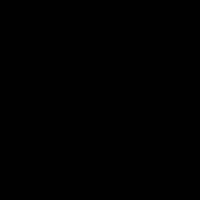

tensor([-28.7152, 299.4125,  84.1611], device='cuda:0')
tensor([-0.0957,  0.9980,  0.2805], device='cuda:0')

 ----------------------------
Across a total of 300 images, the average error was -0.10 and 1.00 pixels for x and y, and 16.07 degrees for orientation

 ----------------------------


In [11]:
n_total = len(test_loader.dataset)

print(n_total)
from IPython.display import display # to display images

import torchvision
img = torchvision.transforms.ToPILImage()(images[0].cpu())
display(img)

avg_err = total_err / n_total 
print(total_err)
print(avg_err)
xerr, yerr, orienterr = avg_err
print('\n ----------------------------')
print('Across a total of %d images, the average error was %0.2f and %0.2f pixels for x and y, \
and %0.2f degrees for orientation' % (n_total, xerr, yerr, math.degrees(orienterr)))
print('\n ----------------------------')

# diagnostics

In [ ]:
from IPython.display import display # to display images
#font = ImageFont.truetype("Arial.ttf",14) # OSError: cannot open resource
font = ImageFont.truetype("/usr/share/fonts/dejavu/DejaVuSans.ttf",14)
def imshow_coord(img, a_label):
    img = torchvision.transforms.ToPILImage()(img)
    draw = ImageDraw.Draw(img)
    #draw.text((10, 25), '(' + np.array2string(np.around(a_label.numpy()), separator=', ') + ')')
    x,y,orient = a_label
    rect_vertices = makeRectangle(5, 15, orient, offset=(x,y))
    draw.polygon(rect_vertices, fill='red')
    draw = draw_crosspointer(a_label, draw, 'green', 'white', length=8)
    display(img)
    
def draw_crosspointer(xy, draw, fillcolor_X='green', fillcolor='white', length=2):
    a,b, orient = tuple(xy)
    draw.line((a-length, b+length, a+length, b-length), fill=fillcolor_X)
    draw.line((a-length, b-length, a+length, b+length), fill=fillcolor_X)
    draw.point((a,b))
    return draw

In [ ]:
import torchvision 
import matplotlib.pyplot as plt
import copy
# get some random training images
with torch.no_grad():
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    outputs = model(images)
    
    # show images
    #imshow_coord(torchvision.utils.make_grid(images), (outputs))


    # print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  # for j in range(4)))
        
    loss = criterion(outputs.to(device), labels.to(device))
 
n =0 
#print(len(labels))
print('x,y truth', labels[n])
print('x,y guess by net', outputs[n])

images_copy = copy.deepcopy(images)
print('image size: ', images_copy[n].size())
print(loss)
print('net output: ')
imshow_coord(images_copy[n], outputs[n])
print('truth label: ')
imshow_coord(images_copy[n], labels[n])

#imagePIL = torchvision.transforms.ToPILImage()(images[n])
#print('PIL image size', imagePIL.size)
#imagePIL.save('test.png')
#display(imagePIL)

#display(Image.open('./data/rect'+str(n)+'.png'))

In [ ]:
%matplotlib inline
#im = Image.open("Mew.jpg")
n = 12
n = np.random.rand()*len(images)
n = int(n)

image = io.imread('./data/rect'+str(n)+'.png')
image_tensor = torch.FloatTensor(image).permute(2, 0, 1) #PIL and torch expect difft orders
coords = torch.FloatTensor(true_coords[n])
with torch.no_grad():
    output = model(image_tensor)

print(true_coords[n])
print(output)
x,y,orient = output.cpu().numpy().flatten()
imshow_coord(image, (x,y, orient))
plt.imshow(image)

In [ ]:
#img = Image.new('RGB', (300,400), 'gray')
import seaborn as sns
sns.set_style("ticks")
n = 0
#imshow_coord(images[n], outputs[n], labels[n])

print(images.size())
a = torchvision.utils.make_grid(images)
print(a.max(), a.min(), a.size())
#a = a / 2 + 0.5     # unnormalize

a = a.cpu().numpy()
a = np.transpose(a,(1,2,0))
print(a.shape)
print(a.ndim)

#ran = a.max() - a.min()
#a = (a/ran )

fig,ax = plt.subplots(1)
# Display the image
ax.imshow(a)
#x,y = labels[0].numpy()
#plt.scatter(x,y, color='g', marker='x', linewidth='1')
labels = labels.cpu()

plt.rcParams['figure.figsize'] = [30,5]
import matplotlib.patches as patches
for i in range(len(labels)):
    x,y, orient = labels[i].numpy()

# class matplotlib.patches.Rectangle(xy, width, height, angle=0.0, **kwargs)[source]

    rect = patches.Rectangle((x + i*IMG_X, y), 1,20,angle=orient, fill=True, color='orange')
    ax.add_patch(rect)
    ax.scatter(x + i*IMG_X, y, color='r', marker='x', linewidth='1')
#plt.imshow(np.transpose(a, (2,0,1)))

In [ ]:
import seaborn as sns
sns.set()
f = plt.subplot()
f.plot(range(len(losses_list)), losses_list)

plt.rcParams['figure.figsize'] = [30, 5]
xposition = np.array(range(num_epoch))  * (total_step)
#print(xposition)
for xc in xposition:
    #plt.axvline(x=xc, color='k', linestyle='--')
    pass
    


In [ ]:
g = plt.subplot()
trunc = 100
g.plot(range(trunc), losses_list[-trunc:])

plt.show()

# Don't run the following cell (takes long time)

In [ ]:
num_epochs = [10,20,50,70,100,150] 
num_classes = 3 # predicting x,y,orientation
batch_size = 5 
learning_rates = [0.001, 0.005, 0.01, 0.1]

meta_losses_list = []
for i in range(len(num_epochs)):
    num_epoch = num_epochs[i]
    learning_rate = learning_rates[0]
    losses_list = []
    print('Training model now... with: %d num_epoch and %d learning rate' % (num_epoch, learning_rate))
    
    total_step = len(train_loader)
    for epoch in range(num_epoch):
        for i_batch, (images, labels) in enumerate(train_loader):

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            # magnify orientation loss
            outputs[2] *= 10
            labels[2] *= 10
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            if (i_batch+1) % 1 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1,
                                                                          num_epochs,
                                                                          i_batch+1,
                                                                          total_step,
                                                                          loss.item()))
                losses_list.append(loss.item())
    meta_losses_list.append(losses_list)

In [ ]:
fig = plt.subplots()
trunc = 100
for l in meta_losses_list:
    plt.plot(range(len(l[-trunc:])), l[-trunc:])
plt.legend()
plt.show()